In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv("creditcard.csv") 

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


EDA - Class Imbalance Check 

Class
0    284315
1       492
Name: count, dtype: int64


<Axes: xlabel='Class', ylabel='count'>

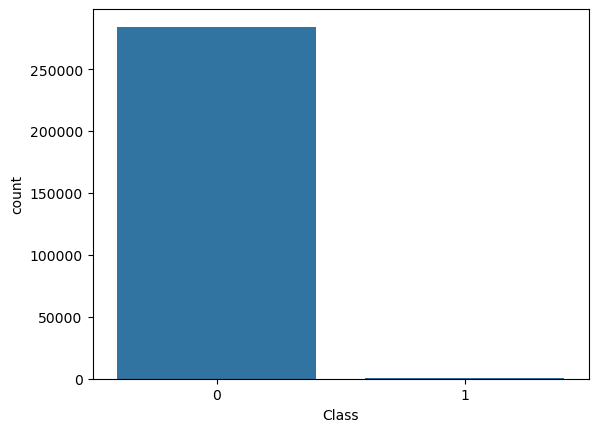

In [8]:
print(df['Class'].value_counts())
sns.countplot(x='Class', data=df)


Check correlations, feature distributions

<Axes: >

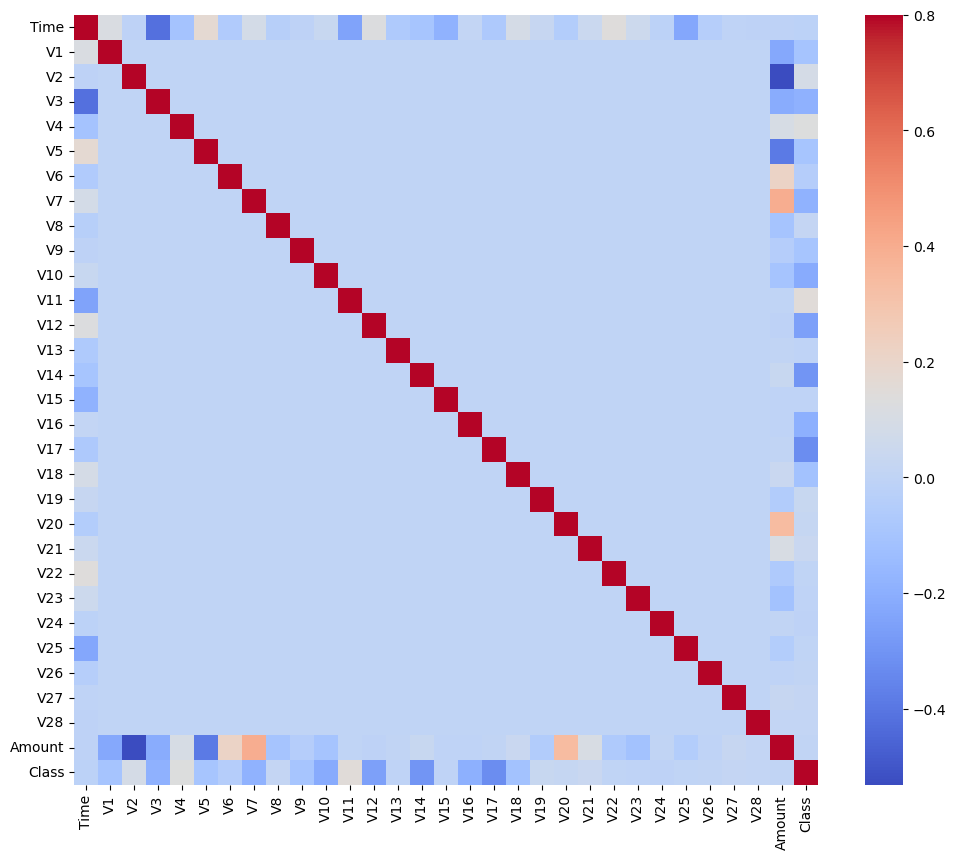

In [11]:
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", vmax=0.8)


 Analyzing amount and time

<Axes: xlabel='Class', ylabel='Amount'>

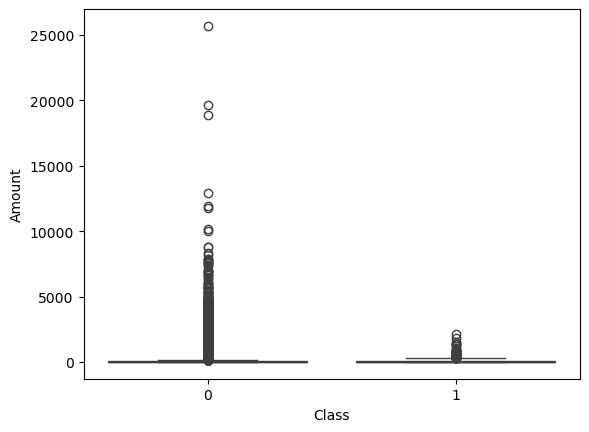

In [14]:
sns.boxplot(x='Class', y='Amount', data=df)


Data preprocessing - feature scaling

In [17]:
df['Amount_scaled'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['Time_scaled'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)


In [19]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Handle Imbalance with SMOTE


In [22]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(y_train.value_counts(), y_train_res.value_counts())


Class
0    227451
1       394
Name: count, dtype: int64 Class
0    227451
1    227451
Name: count, dtype: int64


In [24]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [25]:
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[56832    32]
 [   11    87]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.89      0.80        98

    accuracy                           1.00     56962
   macro avg       0.87      0.94      0.90     56962
weighted avg       1.00      1.00      1.00     56962



Text(0.5, 1.0, 'Precision-Recall Curve')

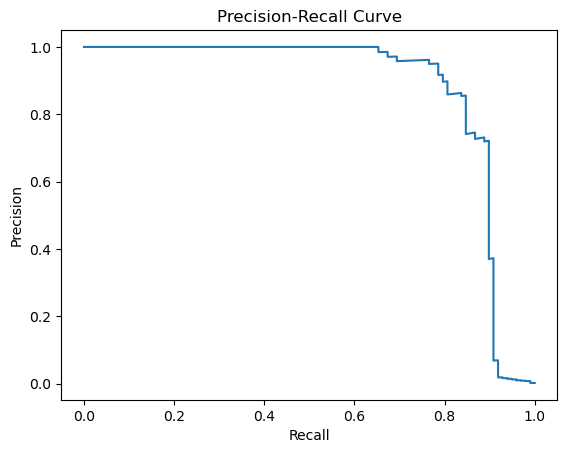

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')


By default, predict() uses threshold = 0.5. Try optimizing this:

In [31]:
threshold = 0.25  # Try lower threshold
y_pred_thresh = (y_proba >= threshold).astype(int)

print(confusion_matrix(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh))


[[56805    59]
 [   10    88]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.60      0.90      0.72        98

    accuracy                           1.00     56962
   macro avg       0.80      0.95      0.86     56962
weighted avg       1.00      1.00      1.00     56962



In [33]:
roc_score = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_score}")


ROC-AUC: 0.9791588308086319


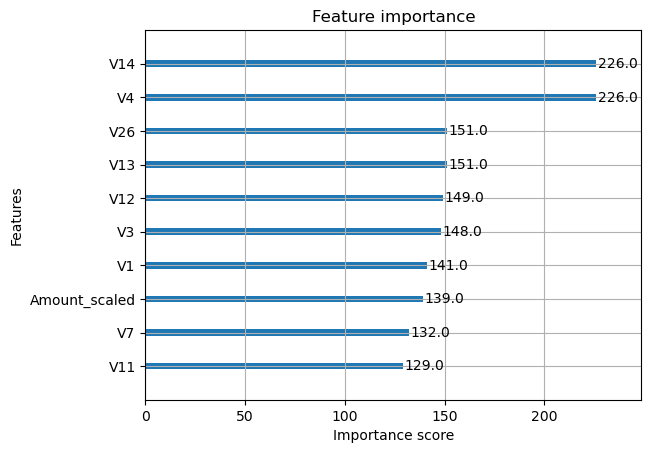

In [39]:
from xgboost import plot_importance
import matplotlib.pyplot as plt 

plot_importance(xgb, max_num_features=10)
plt.show()


In [43]:
import joblib
joblib.dump(xgb, 'fraud_detection_model.pkl')

['fraud_detection_model.pkl']